# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Импортируем библиотеки. Импортируем данные. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv
except:
    data = pd.read_csv

Изучаем общую информацию о полученных данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Строим общую гистограмму для всех числовых столбцов таблицы. 

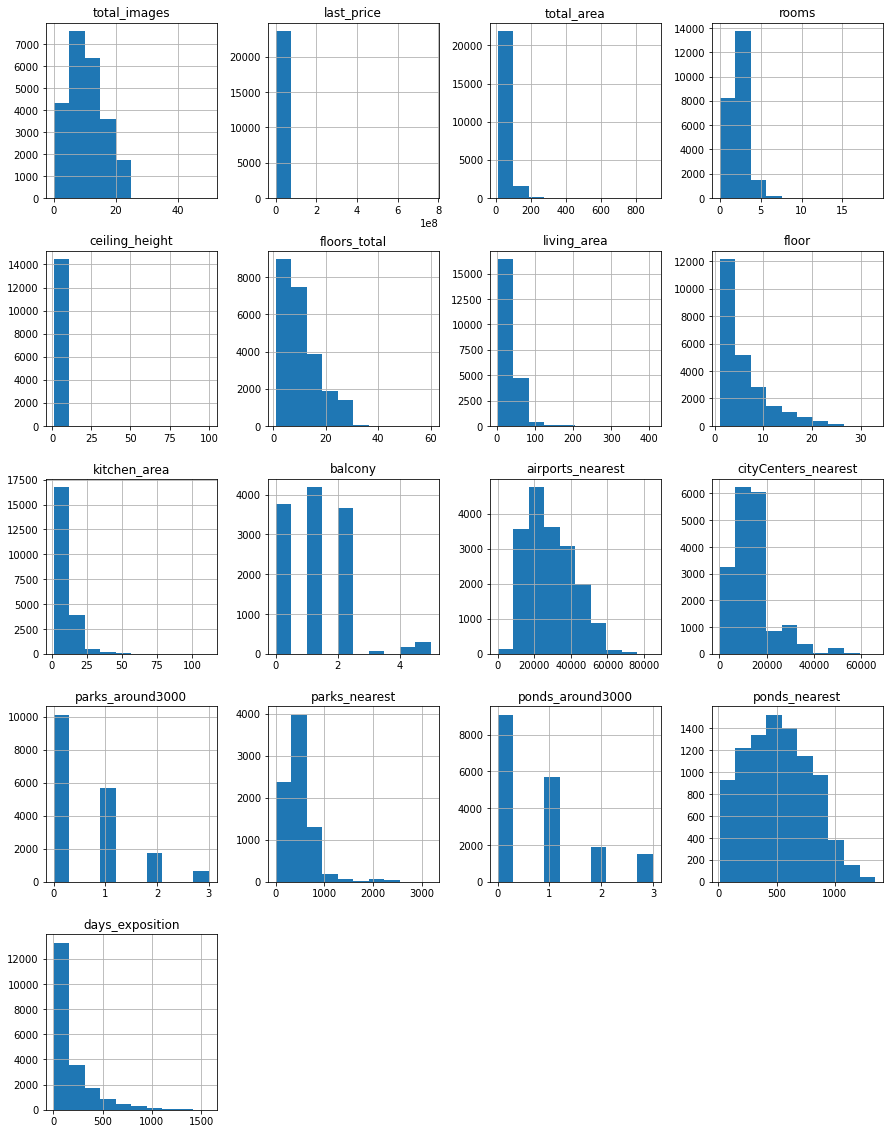

In [5]:
data.hist(figsize=(15, 20));

Максимальное значение заполненных строк составляет 23699. Данные представлены в 22 колонках, включая индекс. Данные имеют типы bool, float64, int64, object. 

### Предобработка данных

Запишем в переменную old_data параметры начального датафрейма.

In [6]:
old_data = data
data.shape[0]

23699

#### Переименовываем столбцы в соответствии со "snake_case". 

In [7]:
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)

#### Проверяем наличие и количество пропущенных значений в данных.

In [8]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

- Пропущены значения в следующих графах:
    * ceiling_height - высота потолков - 9195 - пропущена в трети объявлений, оставим пустое значение
    * floors_total - всего этажей в доме - 86 - пропущенные при заполнении данные, оставим пустое значение
    * living_area -  жилая площадь в квадратных метрах (м²) - 1903 - оставим пустое значение
    * is_apartment - апартаменты (булев тип) - 20924 - для незаполненных значений предполагаем, что это не апартаменты, заполним False
    * kitchen_area - площадь кухни в квадратных метрах (м²) - 2278 - пропущенные при заполнении данные, оставим пустое значение
    * balcony - число балконов - 11519 - значит, в квартире нет балконов, заменим пропуски на 0
    * locality_name - название населённого пункта - 49 - пропущенные при заполнении данные, оставим пустое значение
    * airports_nearest - расстояние до ближайшего аэропорта в метрах (м) - 5542 - аэропортов рядом нет, оставим пустое значение
    * city_centers_nearest - расстояние до центра города (м) - 5519 - центр города неблизко, оставим пустое значение
    * parks_around3000 - число парков в радиусе 3 км - 5518 - предполагаем, что парков в указанном радиусе нет, заменим пропуски на 0
    * parks_nearest -  расстояние до ближайшего парка (м) - 15620 - значит, парков рядом нет, оставим пустое значение
    * ponds_around3000 - число водоёмов в радиусе 3 км - 5518 - предполагаем, что прудов в указанном радиусе нет, заменим пропуски на 0
    * ponds_nearest - расстояние до ближайшего водоёма (м) - 14589 - значит, прудов рядом нет, оставим пустое значение
    * days_exposition - сколько дней было размещено объявление (от публикации до снятия) - 3181 - объявление, вероятно, не снято с публикации, оставим пустое значение
    
Данные в столбцах с указанием парков, аэропортов и водоёмов поблизости заполнялись на основе картографических данных. Пропуски в этих столбцах могут возникнуть вероятно из-за ошибок определения геолокации. Исключать строки с данными пропусками мы не станем, так как они занимают существенную часть датафрейма.   

Заполним пропуски в графе is_apartment

In [9]:
data['is_apartment'] = data['is_apartment'].fillna('False')

Заполним пропуски в графах balcony, parks_around3000, ponds_around3000

In [10]:
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Удалим строки с пустыми значениями floors_total и locality_name - в совокупности их доля составит менее 0,5% и не окажет существенного влияния на результат.

In [11]:
data.dropna(subset=['floors_total','locality_name'], inplace=True)

Апартаменты по сути являются коммерческой недвижимостью, хотя в них и оформляют место для аренды жилья, поэтому пропуски, возможно, связаны с тем, что не все продавцы при публикации объявления указывали, что объект - квартиры, а не апартаменты. Пропуски в столбце is_apartment заполняем значением False.

In [12]:
data['is_apartment'] = data['is_apartment'].astype('bool').fillna(False)

После выполнения данных замен остались пропуски только тех значений, которые невозможно заполнить на данный момент. 

#### Изменим типы данных.

Согласно данным, полученным при вызове функции info, следует изменить тип данных для ряда колонок.
- balcony  - с float64 на int64 (количество балконов может быть только целым числом)
- parks_around3000 - с float64 на int64 (количество парков может быть только целым числом)
- ponds_around3000 - с float64 на int64 (количество прудов может быть только целым числом)
- floors_total - с float64 на int64 (количество этажей может быть только целым числом)
- first_day_exposition - с object на datetime
- is_apartment - с object на bool 

In [13]:
try:
    data['balcony'] = data['balcony'].astype(int)
except:
    print('balcony int type conversion fail')
    
try:        
    data['parks_around3000'] = data['parks_around3000'].astype(int)
except:
    print('parks_around3000 int type conversion fail')
    
try:
    data['ponds_around3000'] = data['ponds_around3000'].astype(int)
except:
    print('ponds_around3000 int type conversion fail')    
    
try:
    data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
except:
    print('first_day_exposition datetime type conversion fail')
    
try:    
    data['is_apartment'] = data['is_apartment'].astype(bool)
except:
    print('first_day_exposition bool type conversion fail')
    
try:
    data['floors_total'] = data['floors_total'].astype(int)
except: 
    print('floors_total int type conversion fail')
    

#### Работа с дубликатами
Изучим уникальные значения в locality_name

In [14]:
print('Количество уникальных значений locality_name:', data['locality_name'].unique().shape[0])
print(data['locality_name'].unique())

Количество уникальных значений locality_name: 364
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское

Для того, чтобы найти явные дубликаты:
- приведем все значения к нижнему регистру;
- заменим "ё" на "е";
- заменим "городской поселок" на "поселок городского типа"

In [15]:
data['locality_name'] = data['locality_name'].str.lower()

In [16]:
data['locality_name'] = data['locality_name'].str.replace('ё','e')

In [17]:
data['locality_name'] = data['locality_name'].str.replace('городской посёлок','поселок городского типа')

Проверяем наличие явных дубликатов.

In [18]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


#### Работа с аномалиями


Оценим распределение значений в данных на предмет наличия выбросов.

In [19]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,14481.000000,23565.000000,21700.000000,23565.000000,21343.000000,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.771283,10.675875,34.454822,5.878124,10.560994,0.593677,28797.082701,14192.656056,0.468831,490.580448,0.589900,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,1.261983,6.594823,22.045359,4.871485,5.900630,0.960660,12632.499735,8613.348153,0.748403,341.572956,0.883966,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.600000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26757.000000,13096.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


В ряде столбцов есть подозрение на наличие аномалий:
- ceiling_height - максимальное значение высоты потолков 100, минимальное 1
- total_area - максимальное значение площади 900, значительная разница между средним и медианой 
- rooms - минимальное значение комнат 0, максимальное - 19, медиана 2 
- last_price - стоимость варьируется в пределах 12190 руб., максимальное значение - 763 млн.руб

##### высота_потолков
Проверим, какие уникальные значения принимает параметр ceiling_height:

In [20]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Встречаются аномальные значения, в частности 1м и 100м. Есть ряд значений выше 20 м, но вероятнее всего эти ошибки вызваны некорректным расположением запятой при внесении данных.

Для ряда ошибочных значений проводим деление на 10.

In [21]:
data.loc[( data['ceiling_height'] >= 20), 'ceiling_height'] = data['ceiling_height'] / 10

Оценим среднее и медианное значения высоты потолков.

In [22]:
print('Средняя высота потолков:', data['ceiling_height'].mean())
print('Медианная высота потолков:', data['ceiling_height'].median())

Средняя высота потолков: 2.7293253228368206
Медианная высота потолков: 2.65


Построим диаграмму размаха для оценки выбросов.

(0.0, 10.0)

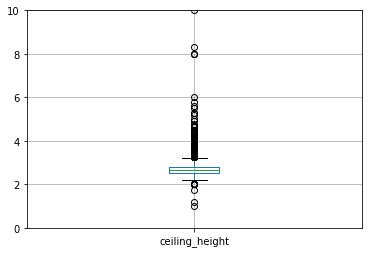

In [23]:
data.boxplot(column=['ceiling_height'])
plt.ylim(0, 10)

Пропущенные значения в столбце ceiling_height заполняем значением 2,7

In [24]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.7)

Делаем срез, убирая из данных значения с высотой более 6 м и менее 2 м.

In [25]:
data = data.query('2 <= ceiling_height < 6')

##### общая площадь
Оценим значения, которые принимает параметр total_area:

In [26]:
data['total_area'].describe()

count    23554.000000
mean        60.323493
std         35.653667
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

(0.0, 200.0)

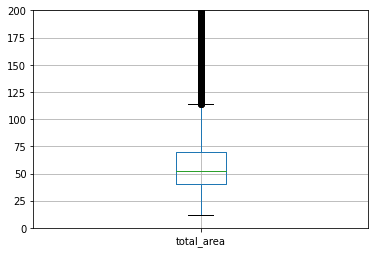

In [27]:
data.boxplot(column=['total_area'])
plt.ylim(0, 200)

Удалим значения общей площади, которые превышают значения 175 кв.м. , так как они являются выбросами, искажающими данные.

In [28]:
data = data.query('total_area < 175')

##### число комнат
Оценим значения, которые принимает параметр rooms:

In [29]:
data['rooms'].describe()

count    23215.000000
mean         2.021839
std          0.975135
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

(0.0, 10.0)

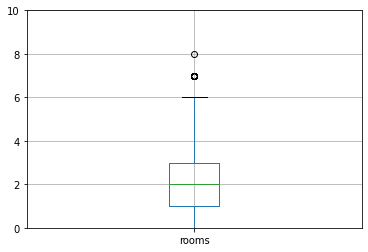

In [30]:
data.boxplot(column=['rooms'])
plt.ylim(0, 10)

Удалим значения с количеством комнат, которые превышают значения 8, так как они являются выбросами, искажающими данные.

In [31]:
data = data.query('rooms < 8')

##### стоимость
Оценим значения, которые принимает параметр last_price:

In [32]:
data['last_price'].describe()

count    2.321400e+04
mean     5.888981e+06
std      5.200307e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.623750e+06
max      1.350000e+08
Name: last_price, dtype: float64

Медианное значение стоимости и среднее значение находятся на приблизительно равном уровне, однако несмотря на наличие ранее выполненного среза данных, присутствует пиковое значение в виде 330 млн. руб.  и минимальное - 12190 руб. Построим диаграмму размаха, чтобы определить есть ли ошибка в заполнении данных. 

(0.0, 150000000.0)

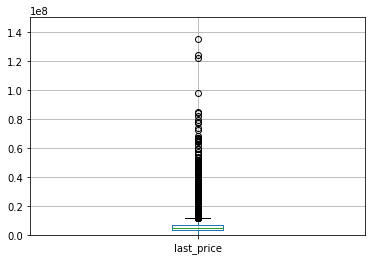

In [33]:
data.boxplot(column=['last_price'])
plt.ylim(0, 150000000)

Удалим значения стоимости, которые превышают значения 100 млн.руб. либо не достигают 100000 руб., так как они являются выбросами, искажающими данные.

In [34]:
data = data.query('100000 < last_price < 100000000')

Проверим процент данных, оставшийся для анализа после удаления выбросов.

In [35]:
new_data = data
new_data.shape[0] / old_data.shape[0]

0.9849352853808614

### Посчитайте и добавьте в таблицу новые столбцы

#### Цена одного квадратного метра


In [36]:
data['cost_per_sq_m'] = data['last_price'] / data['total_area']

#### День публикации объявления

In [37]:
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek

#### Месяц публикации объявления

In [38]:
data['month'] = data['first_day_exposition'].dt.month

#### Год публикации объявления

In [39]:
data['year'] = data['first_day_exposition'].dt.year

#### Тип этажа квартиры (значения — «первый», «последний», «другой»)

In [40]:
def floor_type(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)    

#### Расстояние в км до центра города

In [41]:
data['flat_to_center_km'] = round(data['city_centers_nearest'] / 1000)

### Проведите исследовательский анализ данных

Взглянем на подготовленные для анализа данные после проведенных замен, устранения аномальных значений, смены типа данных и введения новых столбцов.

In [42]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sq_m,day_of_week,month,year,flat_to_center_km
count,23210.000000,2.321000e+04,23210.000000,23210.000000,23210.000000,23210.000000,21386.000000,23210.000000,21031.000000,23210.000000,17699.00000,17719.000000,23210.000000,7803.000000,23210.000000,8793.000000,20119.000000,23210.000000,23210.000000,23210.000000,23210.000000,17719.000000
mean,9.845541,5.873580e+06,57.509148,2.021413,2.710172,10.725248,32.898162,5.888410,10.307585,0.596122,28834.91056,14322.547153,0.458380,491.688197,0.579104,520.906175,179.200457,97908.465508,2.566911,6.401810,2017.375916,14.315932
std,5.655937,5.014572e+06,24.976673,0.974321,0.205128,6.604897,16.553298,4.879437,5.181985,0.960059,12698.30001,8587.532917,0.737055,341.083000,0.875440,277.698817,218.008089,41732.962396,1.789671,3.492683,1.034939,8.595326
min,0.000000,4.300000e+05,12.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.00000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,7962.962963,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.500000,2.000000,7.000000,0.000000,18488.00000,9496.000000,0.000000,288.000000,0.000000,298.000000,45.000000,76389.555342,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.600000e+06,51.400000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26876.00000,13174.000000,0.000000,456.000000,0.000000,505.000000,94.000000,94786.729858,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.618750e+06,68.100000,3.000000,2.700000,16.000000,42.000000,8.000000,11.800000,1.000000,37407.00000,16333.000000,1.000000,613.000000,1.000000,733.000000,229.000000,113732.806234,4.000000,10.000000,2018.000000,16.000000
max,50.000000,9.800000e+07,174.500000,7.000000,5.800000,60.000000,140.000000,33.000000,93.000000,5.000000,84869.00000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,848484.848485,6.000000,12.000000,2019.000000,66.000000


Изучим основные параметры объектов.

#### Общая площадь
Построим гистограмму для оценки распределения объектов по общей площади.

<AxesSubplot:ylabel='Frequency'>

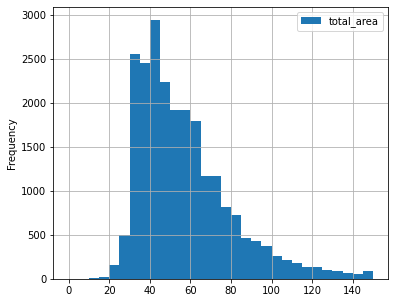

In [43]:
data.plot(y = 'total_area', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (0,150))

Представлены объявления с широким диапазоном параметра - от 12 кв.м. до 150 кв.м. Распределение объектов по общей площади соответствует нормальному распределению. Наиболее часто встречаются объекты с площадью от 30 до 50 кв.м.

#### Жилая площадь
Построим гистограмму для оценки распределения объектов по жилой площади.

<AxesSubplot:ylabel='Frequency'>

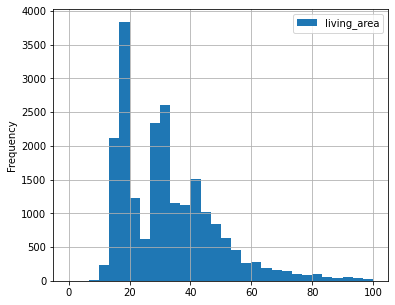

In [44]:
data.plot(y = 'living_area', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (0,100))

Представлены объявления с диапазоном параметра до 100 кв.м. Наибольшая доля приходится на пик до 20 кв.м., второй пик наблюдается на отметке около 30 кв.м. Это характерно для 1-2 комнатных квартир, либо небольших 3-комнатных, доля которых в датафрейме наиболее значительна.

#### Площадь кухни

Построим гистограмму для оценки распределения объектов по площади кухни.

<AxesSubplot:ylabel='Frequency'>

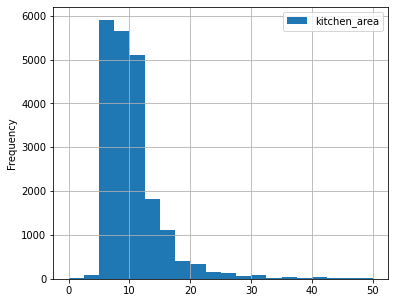

In [45]:
data.plot(y = 'kitchen_area', kind = 'hist', bins = 20, grid=True, figsize = (6,5), range = (0,50))

In [46]:
data['kitchen_area'].describe()

count    21031.000000
mean        10.307585
std          5.181985
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max         93.000000
Name: kitchen_area, dtype: float64

Представлены объявления с широким диапазоном параметра - от 1.3 кв.м. до 93 кв.м. Распределение объектов соответствует распределению Пуассона. Наиболее часто встречаются объекты с площадью кухни от 6 кв.м. до 12 кв.м.

#### Цена объекта

Построим гистограмму для оценки распределения объектов по цене.

In [47]:
data['last_price'].describe()

count    2.321000e+04
mean     5.873580e+06
std      5.014572e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.618750e+06
max      9.800000e+07
Name: last_price, dtype: float64

In [48]:
data['last_price_mln'] = data['last_price']/1000000

Text(0.5, 0, 'Цена, млн.руб')

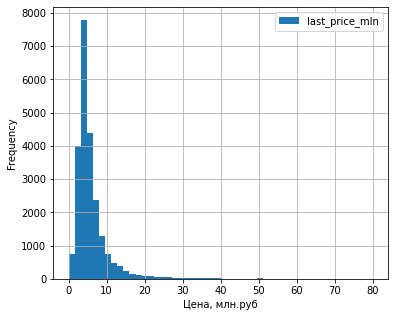

In [49]:
data.plot(y = 'last_price_mln', kind = 'hist', bins = 50, grid=True, range = (0,80), figsize = (6,5))
plt.xlabel('Цена, млн.руб')

После удаления аномалий представлены объявления с диапазоном параметра - от 4.3 млн.рублей до 98 млн.рублей. Распределение объектов соответствует распределению Пуассона. Среднее значение в 5.01 млн. руб., медиана 5.87 млн. руб. 

#### Количество комнат

Построим гистограмму для оценки распределения объектов по количеству комнат

<AxesSubplot:ylabel='Frequency'>

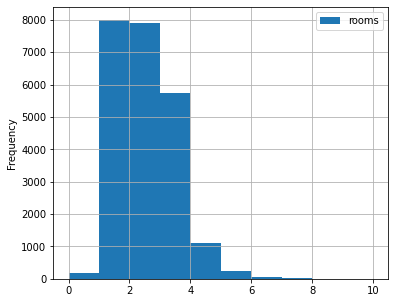

In [50]:
data.plot(y = 'rooms', kind = 'hist', bins = 10, grid=True, figsize = (6,5), range=(0,10))

In [51]:
data['rooms'].describe()

count    23210.000000
mean         2.021413
std          0.974321
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

После удаления выбросов представлены объявления с диапазоном параметра 0 комнат до 7 комнат. Наибольшая доля объявлений приходится на 1,2 комнатные квартиры. Наиболее распространенными являются объекты с 2 комнатами. 

#### Высота потолков

Построим гистограмму для оценки распределения объектов по высоте потолков.

<AxesSubplot:ylabel='Frequency'>

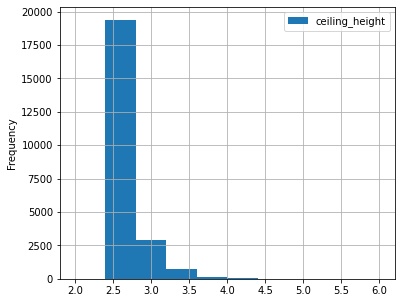

In [52]:
data.plot(y = 'ceiling_height', kind = 'hist', bins = 10, grid=True, figsize = (6,5), range = (2,6))

После удаления выбросов и приведения ошибочных значений к нормальному виду, а также выполненному заполнению пропусков, представлены объявления с диапазоном параметра от 2 м. до 5.8 м. Наибольшая доля объектов имеют параметр близкий к медианному значению - 2,7 м.

#### Этаж квартиры

Построим гистограмму для оценки распределения объектов по этажу расположения.

<AxesSubplot:ylabel='Frequency'>

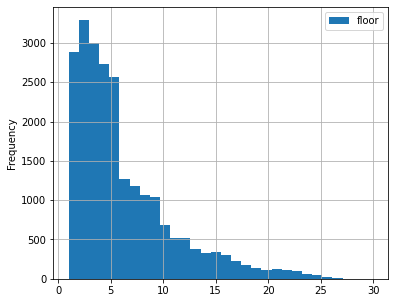

In [53]:
data.plot(y = 'floor', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (1,30))

In [54]:
data['floor'].describe()

count    23210.000000
mean         5.888410
std          4.879437
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Представлены объявления с диапазоном параметра - от 1 этажа до 33 этажей. Распределение объектов соответствует распределению Пуассона. Среднее значение и медиана близки, что, вероятно, вызвано большим количеством 5 этажных домов среди объектов недвижимости. 

#### Тип этажа квартиры

Построим гистограмму для оценки распределения объектов по типу этажа квартиры (первый, последний, другой).

<AxesSubplot:>

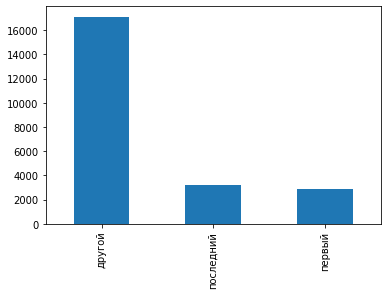

In [55]:
data['floor_type'].value_counts().plot.bar()

In [56]:
data['floor_type'].describe()

count      23210
unique         3
top       другой
freq       17100
Name: floor_type, dtype: object

Наибольшее количество объявлений относятся к типу "другой". Типы "первый" и "последний" представлены практически в равной степени. 

#### Общее количество этажей в доме

Построим гистограмму для оценки распределения объектов по этажности домов, в которых они находятся.

<AxesSubplot:ylabel='Frequency'>

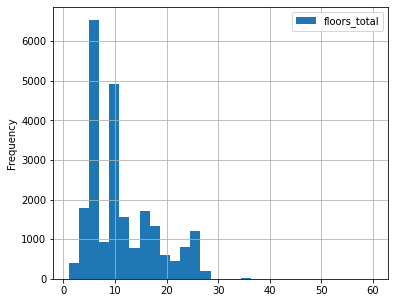

In [57]:
data.plot(y = 'floors_total', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (1,60))

In [58]:
data['floors_total'].describe()

count    23210.000000
mean        10.725248
std          6.604897
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Представлены объявления с диапазоном параметра от 1 этажа до 60 этажей. Наблюдается два пика на отметках, соответствующих 5 и 10 этажам, что близко к значениям среднего и медианы.

#### Расстояние до центра города в километрах

Построим гистограмму для оценки распределения объектов по расстоянию до центра города.

<AxesSubplot:ylabel='Frequency'>

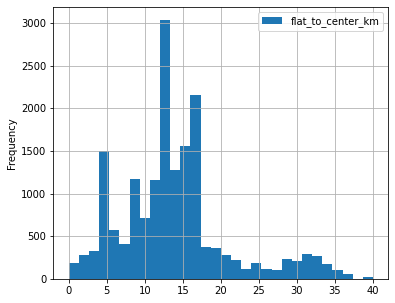

In [59]:
data.plot(y = 'flat_to_center_km', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (0,40))

In [60]:
data['flat_to_center_km'].describe()

count    17719.000000
mean        14.315932
std          8.595326
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: flat_to_center_km, dtype: float64

Наибольшая часть объявлений находится в диапазоне  от 10 до 16 км от центра. Пик значений соответствует медианному значению 14 км. Выявлен локальный пик на отметке 5 км от центра города.

#### Расстояние до ближайшего аэропорта

Построим гистограмму для оценки распределения объектов по расстоянию до ближайшего аэропорта.

<AxesSubplot:ylabel='Frequency'>

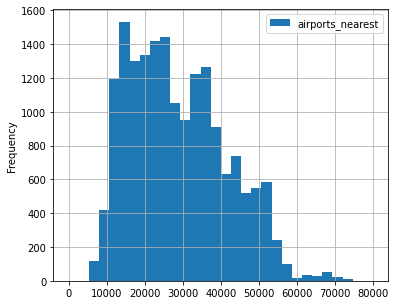

In [61]:
data.plot(y = 'airports_nearest', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (0,80000))

In [62]:
data['airports_nearest'].describe()

count    17699.00000
mean     28834.91056
std      12698.30001
min          0.00000
25%      18488.00000
50%      26876.00000
75%      37407.00000
max      84869.00000
Name: airports_nearest, dtype: float64

Представленные объекты находятся на удалении от аэропорта в пределах диапазона от 5000 м. до 75000 м. Медианное значение составляет 28834 м. 

#### Расстояние до ближайшего парка

Построим гистограмму для оценки распределения объектов по расстоянию до ближайшего парка.

<AxesSubplot:ylabel='Frequency'>

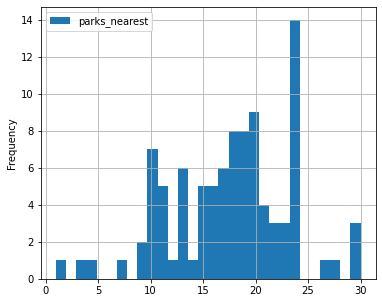

In [63]:
data.plot(y = 'parks_nearest', kind = 'hist', bins = 30, grid=True, figsize = (6,5), range = (1,30))

In [64]:
data['parks_nearest'].describe()

count    7803.000000
mean      491.688197
std       341.083000
min         1.000000
25%       288.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Представленные объекты находятся на удалении от парка в пределах диапазона от 1 м. до 3190 м. Медианное значение составляет 491 м. 

#### День и месяц публикации объявления

Построим гистограмму для оценки распределения объектов по времени публикации.

<AxesSubplot:xlabel='day_of_week'>

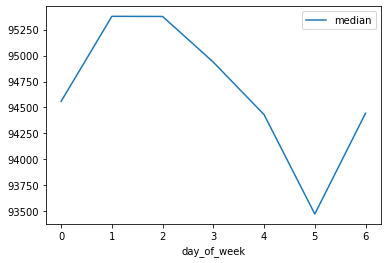

In [65]:
pivot_table_weekday_exposition = data.pivot_table(index = 'day_of_week', values = 'cost_per_sq_m', \
                                                  aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

<AxesSubplot:xlabel='month'>

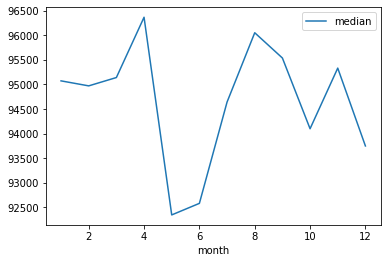

In [66]:
pivot_table_month_exposition = data.pivot_table(index = 'month', values = 'cost_per_sq_m', \
                                                aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')

Наименьшее количество публикаций наблюдается в субботы. Пик публикаций приходится на вторник и среду
По результатам месячных данных, минимальное число объявлений характерно для мая и июня, возможно, имеет место сезонность. Наибольшее количество объявлений было опубликовано в апреле.

#### Изучим, как быстро продавались квартиры
Построим гистограмму по данным столбца  days_exposition

<AxesSubplot:ylabel='Frequency'>

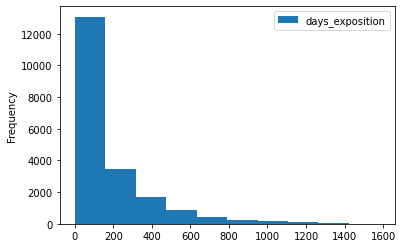

In [67]:
data.plot(y='days_exposition', kind='hist', bins=10)

Оценим среднее и медиану:

In [68]:
data['days_exposition'].describe()

count    20119.000000
mean       179.200457
std        218.008089
min          1.000000
25%         45.000000
50%         94.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

(0.0, 600.0)

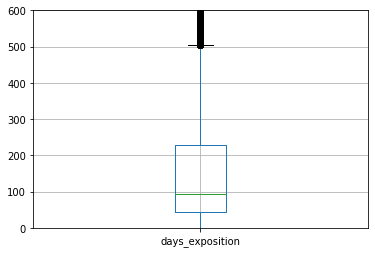

In [69]:
data.boxplot(column=['days_exposition'])
plt.ylim(0, 600)

Вывод: Среднее значение дней до продажи объекта составляет 218. Медиана равна 179 дням. 
Быстрыми продажами можно считать все продажи совершенные быстрее 179 дней.
Необычайно долгими можно считать продажи, совершенные в срок более 500 дней, как выпадающие значение из зоны нормального распределения. 

#### Оценка факторов, которые оказывают наибольшее влияние на полную стоимость объекта
Изучим, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

##### Зависимость цены от общей площади:

0.7263954476246616

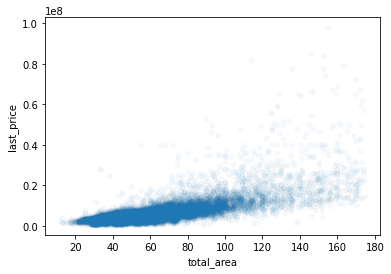

In [70]:
data.plot(kind = 'scatter', y = 'last_price', x = 'total_area', alpha = 0.03)
data['total_area'].corr(data['last_price'])

Цена на объекты недвижимости практически линейно зависит от общей площади в квартире - чем она больше, тем выше стоимость. Наблюдаются отдельные пики, что может быть обусловлено наличием ремонта, расположением, либо какими-то дополнительными факторами. Коэффициент Пирсона составляет 0,72, что подтвеждает наличие существенной связи между параметрами.

##### Зависимость цены от жилой площади:

0.609782422889909

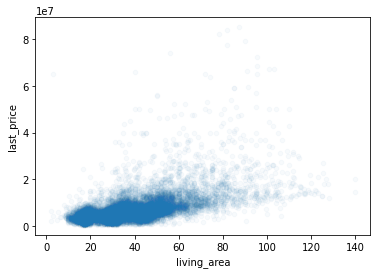

In [71]:
data.plot(kind = 'scatter', y = 'last_price', x = 'living_area', alpha = 0.03)
data['living_area'].corr(data['last_price'])

Цена на объекты недвижимости практически линейно зависит от жилой площади в квартире - чем она больше, тем выше стоимость. Наблюдаются отдельные пики, что может быть обусловлено наличием ремонта, расположением, либо какими-то дополнительными факторами. Коэффициент Пирсона составляет 0,6, что подтвеждает наличие связи между параметрами, однако менее существенной, чем в случае с общей площадью.

##### Зависимость цены от площади кухни:

0.5624262263203335

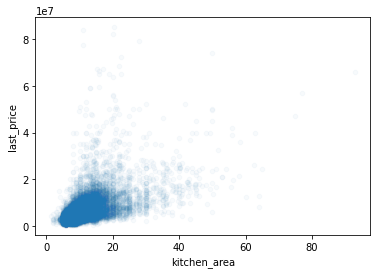

In [72]:
data.plot(kind = 'scatter', y = 'last_price', x = 'kitchen_area', alpha = 0.03)
data['kitchen_area'].corr(data['last_price'])

Цена на объекты недвижимости зависит от площади кухни в квартире - чем она больше, тем выше стоимость - справедливо для большинства случаев. Наблюдаются отдельные пики, что может быть обусловлено наличием ремонта, расположением, либо какими-то дополнительными факторами. Коэффициент Пирсона составляет 0,56, что подтвеждает наличие связи между параметрами, однако менее существенной, чем в случае с общей площадью и жилой площадью.

##### Зависимость цены от количества комнат:

<AxesSubplot:xlabel='rooms'>

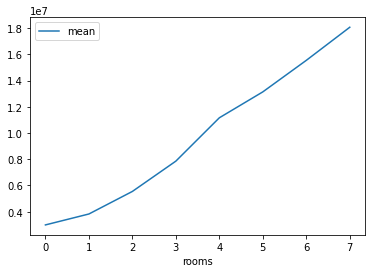

In [73]:
pivot_table_rooms = data.pivot_table(index='rooms', values='last_price', aggfunc = 'mean')

pivot_table_rooms.columns = ['mean']
pivot_table_rooms.plot(y = 'mean')

Цена на объекты недвижимости практически линейно зависит от количества комнат в квартире - чем их больше, тем выше стоимость.

##### Зависимость цены от этажа, на котором расположена квартира (первый, последний, другой):

<AxesSubplot:xlabel='floor_type'>

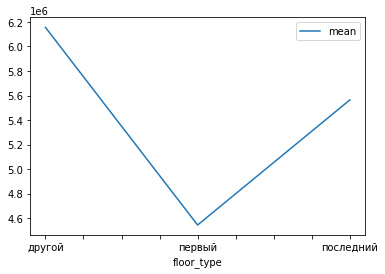

In [74]:
pivot_table_floor_type = data.pivot_table(index='floor_type', values='last_price', aggfunc = 'mean')

pivot_table_floor_type.columns = ['mean']
pivot_table_floor_type.plot(y = 'mean')

Цена на объекты недвижимости, расположенные на первом этаже, является самой низкой. Наибольшее значение для типа этажа "другой". 

##### Зависимость цены от даты  размещения объявления (день недели, месяц, год):

Построим графики для оценки зависимости цены объекта от времени размещения объявлния:

<AxesSubplot:xlabel='year'>

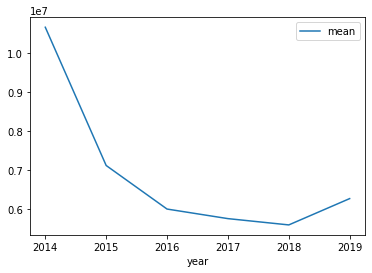

In [75]:
pivot_table_publication_year = data.pivot_table(index='year', values='last_price', aggfunc = 'mean')
pivot_table_publication_year.columns = ['mean']
pivot_table_publication_year.plot(y = 'mean')

<AxesSubplot:xlabel='month'>

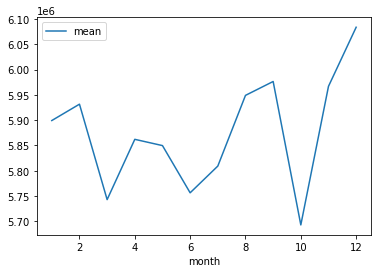

In [76]:
pivot_table_publication_month = data.pivot_table(index='month', values='last_price', aggfunc = 'mean')
pivot_table_publication_month.columns = ['mean']
pivot_table_publication_month.plot(y = 'mean')

<AxesSubplot:xlabel='day_of_week'>

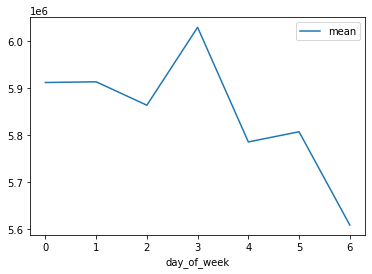

In [77]:
pivot_table_publication_day = data.pivot_table(index='day_of_week', values='last_price', aggfunc = 'mean')
pivot_table_publication_day.columns = ['mean']
pivot_table_publication_day.plot(y = 'mean')

array([[<AxesSubplot:xlabel='day_of_week', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='month', ylabel='day_of_week'>,
        <AxesSubplot:xlabel='year', ylabel='day_of_week'>],
       [<AxesSubplot:xlabel='day_of_week', ylabel='month'>,
        <AxesSubplot:xlabel='month', ylabel='month'>,
        <AxesSubplot:xlabel='year', ylabel='month'>],
       [<AxesSubplot:xlabel='day_of_week', ylabel='year'>,
        <AxesSubplot:xlabel='month', ylabel='year'>,
        <AxesSubplot:xlabel='year', ylabel='year'>]], dtype=object)

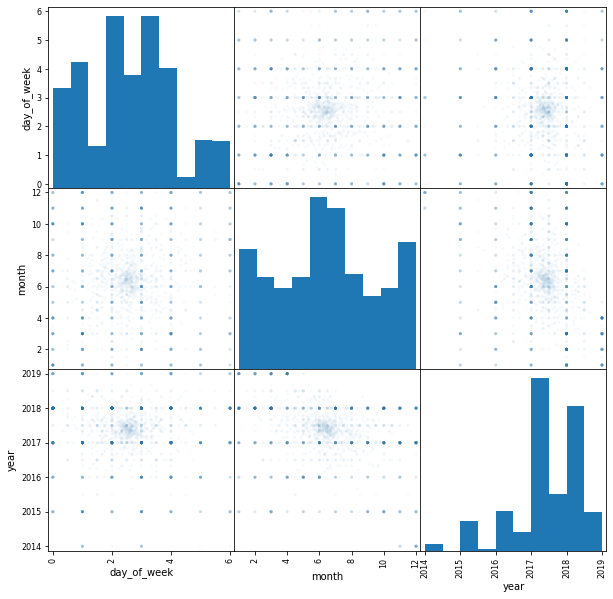

In [78]:
exposition_date = data.pivot_table(index='last_price', values=['day_of_week', 'month', 'year'], aggfunc='mean')
exposition_date.corr()
pd.plotting.scatter_matrix(exposition_date, figsize=(10, 10), alpha=0.03)

#### Расчет средней цены одного квадратного метра 
Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [79]:
median_price_per_sq_m = data.pivot_table(index='locality_name', values='cost_per_sq_m', aggfunc=['count', 'median'])
median_price_per_sq_m.columns = ['count', 'median']
median_price_per_sq_m = median_price_per_sq_m.sort_values('count', ascending=False).head(10)
median_price_per_sq_m 

,count,median
locality_name,,
санкт-петербург,15322,104615.384615
посeлок мурино,520,85878.462169
посeлок шушары,439,76829.268293
всеволожск,398,65789.473684
пушкин,363,99987.179487
колпино,337,74722.222222
посeлок парголово,326,91780.224134
гатчина,307,67796.610169
деревня кудрово,299,91860.465116


In [80]:
#самая низкая цена за кв.м.
median_price_per_sq_m[median_price_per_sq_m['median']==median_price_per_sq_m['median'].min()]

,count,median
locality_name,,
выборг,235,58158.319871


In [81]:
#самая высокая цена за кв.м.
median_price_per_sq_m[median_price_per_sq_m['median']==median_price_per_sq_m['median'].max()]

,count,median
locality_name,,
санкт-петербург,15322,104615.384615


Вывод: Самая высокая стоимость квадратного метра наблюдается в Санкт-Петербурге. Самая низкая стоимость квадратного метра наблюдается в Выборге.

#### Оценка стоимости объектов в зависимости от их расстояния до центра города

Проведем оценку квартир Санкт-Петербурга. Подсчитаем среднюю цену для каждого километра.

<AxesSubplot:xlabel='city_centers_nearest'>

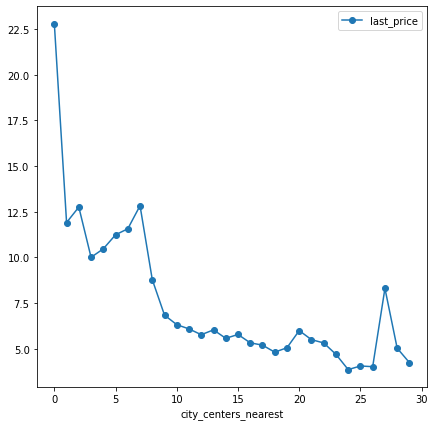

In [82]:
flats_in_spb = data.query('locality_name == "санкт-петербург"')
flats_in_spb_cost = flats_in_spb.loc[:, ['locality_name', 'city_centers_nearest','last_price']]

flats_in_spb_mean_cost_per_m = flats_in_spb['last_price'].mean() #средняя цена кв.м
flats_in_spb_cost['mean_price_for_km'] = flats_in_spb_mean_cost_per_m / flats_in_spb['city_centers_nearest']

#приведение столбца к км и округление значения
flats_in_spb_cost['city_centers_nearest'] = (flats_in_spb_cost['city_centers_nearest']/1000).round()
#переведем цену в млн.руб.
flats_in_spb_cost['last_price'] = flats_in_spb_cost['last_price']/1000000


flats_in_spb_pivot = flats_in_spb_cost.pivot_table(index='city_centers_nearest', values='last_price', aggfunc='mean')
flats_in_spb_pivot.plot(y='last_price', marker='o', figsize=(7, 7))

<AxesSubplot:xlabel='city_centers_nearest', ylabel='mean_price_for_km'>

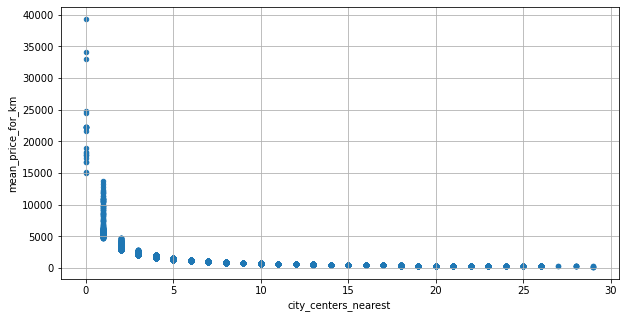

In [83]:
flats_in_spb_mean_cost_per_m = flats_in_spb['last_price'].mean() #средняя цена кв.м
flats_in_spb_cost['mean_price_for_km'] = flats_in_spb_mean_cost_per_m / flats_in_spb['city_centers_nearest']
flats_in_spb_cost.plot(x='city_centers_nearest', y='mean_price_for_km', kind='scatter', figsize=(10, 5), grid=True)

Пик стоимости объектов наблюдается в пределах 7 км от центра города. При удалении от центра стоимость постепенно снижается и становится линейной зависимостью. Наибольшие значения средней цены кв.м. на километр находятся в зоне до 3 км от центра города. Отдельный пик (отметка 28 км), вероятно, связан с классом жилья, либо близостью к культурным объектам.

### Общий вывод

Проведен анализ архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за период 2014-2019 гг., для определения рыночной стоимости объектов недвижимости, а также для дальнейшего отслеживания потенциальных случаев мошенничества и аномалий.

#### Предообработка данных
Входные данные были оценены с точки зрения их полноты и достаточности для анализа. Выявлено наличие пропусков в данных по столбцам. Причиной может являться человеческий фактор и технические ошибки при заполнении данных.

Аномалии были выявлены в столбцах ceiling_height, total_area, rooms, last_price. Ошибочные значения в ceiling_height пересчитаны, пропущенные данные заменены на значение медианы. Построены диаграммы размаха, выбросы удалены из данных. 

Исправлены типы данных в датафрейме. 

Выявлены дубликаты, проведено их удаление из данных.
По результатам предобработки для анализа сохранено 98,4% данных.


#### Анализ данных
Построены гистограммы для оценки параметров объектов (площадь, цена, число комнат, высота потолков, этаж размещения и др.).
Построены диаграммы рассеяния и матрица диаграмм рассеяния для оценки нелинейных зависимостей.
 
Изучили наличие зависимости цены от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).


#### Выводы
 1. Цена на объекты недвижимости прямо зависят от общей площади, жилой площади и площади кухни. Наиболее сильная зависимость наблюдается от общей площади(Коэффициент Пирсона составляет 0,72. Для зависимости от жилой площади коэффициент Пирсона составил 0,6, а для зависимости от площади кухни - 0,56 
 2. Цена на объекты недвижимости практически линейно зависит от количества комнат в квартире - чем их больше, тем выше стоимость.
 3. Квартиры на первом и последнем этаже дешевле, чем на любом другом.
 4. Быстрыми продажами можно считать все продажи совершенные быстрее 179 дней (медианное значение).
 5. Необычайно долгими можно считать продажи, совершенные в срок более 500 дней, как выпадающие значение из зоны нормального распределения. 
 6. Дороже всего кадратный метр стоит в Санкт-Петербурге, дешевле всего квартиру можно купить в Выборге.
 7. Пик стоимости объектов в Санкт-Петербурге наблюдается в пределах 7 км от центра города. При удалении от центра стоимость постепенно снижается и становится линейной зависимостью. Наибольшие значения средней цены кв.м. на километр находятся в зоне до 3 км от центра города.

 Между временем размещения публикации и ценой обнаружена следующая взаимосвязь:
- Наименьшие значения цены продажи были зафиксированы в 2018 году, максимум достигнут в 2014 году. 
- Наилучшие значения по данным месяца приходятся на декабрь, самые низкие цены - у объектов, размещенных в октябре, марте и июне.
- Самые низкие цены продажи по дню размещения зафиксированы в воскресенье, самые высокие - в четверг.
